## Important Libraries

In [57]:
# Imported Libraries
import numpy as np
import random
import pandas as pd
import os
import matplotlib.pyplot as plt

## Guest Class

In [58]:
'''
    The Guest class appears to be a simple class that represents a guest staying at a hotel. 
'''
class Guest:
    def __init__(self, name, discount):
        self.name = name
        self.discount = discount
        self.allocated_hotel = None


## Hotel Class

In [59]:
'''
    The Hotel class represent a hotel with rooms that can be allocated to customers.
'''
class Hotel:
    def __init__(self, name, rooms, price):
        self.name = name
        self.rooms = rooms
        self.price = price
        self.customers = []

    def allocate_customer(self, guest):
        if self.rooms > 0:
            self.rooms -= 1
            self.customers.append(guest)
            return True
        return False

    def calculate_total_earnings(self):
        return self.price * len(self.customers)


## DataManager Class

In [60]:
'''
    The DataManager class is responsible for reading data from Excel files
    and providing access to this data through methods.
    It used for managing and retrieving data related to hotels, guests, and guest preferences.
'''

class DataManager:
    def __init__(self, hotels_path, guests_path, preferences_path):
        self.hotels_df = pd.read_excel(hotels_path, index_col=0)
        self.guests_df = pd.read_excel(guests_path, index_col=0)
        self.preferences_df = pd.read_excel(preferences_path, index_col=0)
        self.preferences_df.sort_values(by=['guest', 'priority'], inplace=True)

    def get_hotels(self):
        return self.hotels_df

    def get_guests(self):
        return self.guests_df

    def get_preferences(self):
        return self.preferences_df


## Allocator Class

In [61]:
'''
    Program implements a hotel room allocation system. 
    Includes several classes and methods for allocating hotel rooms to guests based on various strategies.
'''

class Allocator:
    # Initializer for the Allocator class that sets up data from the DataManager
    def __init__(self, data_manager):
        self.hotels_df = data_manager.get_hotels()  # Retrieve hotels data from DataManager
        self.guests_df = data_manager.get_guests()  # Retrieve guests data from DataManager
        self.preferences_df = data_manager.get_preferences()  # Retrieve preferences data from DataManager
        self.guest_allocation_info = []  # Initialize a list to store allocation information

    # Method to load data into Hotel and Guest objects for processing
    def load_data(self):
        # Create Hotel objects from hotels DataFrame
        self.hotels = [Hotel(row['hotel'], row['rooms'], row['price']) for index, row in self.hotels_df.iterrows()]
        # Create Guest objects from guests DataFrame
        self.guests = [Guest(row['guest'], row['discount']) for index, row in self.guests_df.iterrows()]

    # Allocation strategy based on the price of the hotel
    def price_allocation(self):
        self.load_data()  # Load the hotel and guest data
        self.hotels.sort(key=lambda hotel: hotel.price)  # Sort hotels by price in ascending order
        self.allocate_rooms()  # Allocate rooms to guests based on the sorted order

    # Allocation strategy based on customer preferences
    def customer_preference_allocation(self):
        self.load_data()  # Load the hotel and guest data
        # Create an array of guest names and sort the guests by their names
        guest_names = np.array([guest.name for guest in self.guests])
        sorted_indices = np.argsort(guest_names)
        self.guests = [self.guests[i] for i in sorted_indices]
        self.allocate_rooms(preferential=True)  # Allocate rooms based on guest preferences

    # Allocation strategy that randomly allocates guests to hotels
    def random_allocation(self):
        self.load_data()  # Load the hotel and guest data
        random.shuffle(self.guests)  # Randomly shuffle the list of guests
        self.allocate_rooms()  # Allocate rooms to the shuffled list of guests

    # Allocation strategy based on the availability of rooms in hotels
    def availability_allocation(self):
        self.load_data()  # Load the hotel and guest data
        # Sort hotels by the number of available rooms in descending order
        self.hotels.sort(key=lambda hotel: hotel.rooms, reverse=True)
        self.allocate_rooms()  # Allocate rooms to guests based on the sorted order


    def allocate_rooms(self, preferential=False):
        for guest in self.guests:
            allocated = False
            guest_preferences = self.preferences_df[self.preferences_df['guest'] == guest.name].sort_values(by='priority')['hotel'].tolist()

            if preferential:
                # Try to allocate based on preferences
                for hotel_name in guest_preferences:
                    allocated = self.try_allocate(guest, hotel_name)
                    if allocated:
                        break

            if not allocated:
                # If preferred hotels are full, allocate to any available hotel
                for hotel in self.hotels:
                    if hotel.allocate_customer(guest):
                        guest.allocated_hotel = hotel.name
                        self.guest_allocation_info.append((guest.name, hotel.name, hotel.price * (1 - guest.discount)))
                        allocated = True
                        break

            if not allocated:
                print(f"No available rooms for {guest.name}")
                self.guest_allocation_info.append((guest.name, None, 0))  # No hotel allocated and no earnings

            # Calculate and store satisfaction rate for each guest
            guest.satisfaction = 100 if guest.allocated_hotel in guest_preferences else 0


    def try_allocate(self, guest, hotel_name):
        for hotel in self.hotels:
            if hotel.name == hotel_name and hotel.allocate_customer(guest):
                guest.allocated_hotel = hotel.name
                self.guest_allocation_info.append((guest.name, hotel.name))
                return True
        return False

    def calculate_customer_satisfaction(self):
        # Using NumPy for efficient calculations
        satisfaction_counts = np.array([guest.allocated_hotel in self.preferences_df[self.preferences_df['guest'] == guest.name].sort_values(by='priority')['hotel'].tolist() for guest in self.guests])
        satisfaction_count = np.sum(satisfaction_counts)
        return np.divide(satisfaction_count, len(self.guests)) * 100

    def get_hotel_earnings(self):
        # calculates the hotel's total earnings based on allocated guests.
        return {hotel.name: hotel.calculate_total_earnings() for hotel in self.hotels}
    
    def get_top_earning_hotels(self, top_n=10):
        earnings = self.get_hotel_earnings()
        # Sort the hotels by earnings and get the top ones
        top_earning_hotels = sorted(earnings.items(), key=lambda x: x[1], reverse=True)[:top_n]
        return top_earning_hotels

    def display_report(self):
        total_customers = len(self.guests)
        total_rooms_occupied = sum(len(hotel.customers) for hotel in self.hotels)
        total_hotels_occupied = sum(1 for hotel in self.hotels if len(hotel.customers) > 0)
        total_earnings = sum(hotel.calculate_total_earnings() for hotel in self.hotels)
        
        # Assemble the report DataFrame with additional columns for satisfaction and earnings
        report_data = {
            "Guest": [guest.name for guest in self.guests],
            "Allocated Hotel": [guest.allocated_hotel for guest in self.guests],
            # Calculate the satisfaction rate for each guest
            "Satisfaction Rate (%)": [self.calculate_individual_satisfaction(guest) for guest in self.guests],
            # Calculate the earnings for each guest
            "Earned Money": [self.calculate_individual_earnings(guest) for guest in self.guests]
        }

        # Create a DataFrame for the report
        detailed_report_df = pd.DataFrame(report_data)

        # Calculate overall satisfaction and earnings
        total_satisfaction = np.mean([guest.satisfaction for guest in self.guests if guest.satisfaction is not None])
        total_earnings = sum([guest.earnings for guest in self.guests if guest.earnings is not None])

        # Create a summary DataFrame
        summary_data = {
            "Number of customers accommodated": len(self.guests),
            "Number of rooms occupied": sum(1 for guest in self.guests if guest.allocated_hotel),
            "Total volume of business": total_earnings,
            "Customer satisfaction rate": f"{total_satisfaction}%"
        }
        summary_df = pd.DataFrame([summary_data])

        hotel_earnings = self.get_hotel_earnings()

        return detailed_report_df, summary_df, hotel_earnings

    def save_allocation_info_to_excel(self, output_file):
        # Ensure directory exists
        os.makedirs(os.path.dirname(output_file), exist_ok=True)

        # Create a DataFrame from the allocation information
        # Update the columns to match the data
        allocation_df = pd.DataFrame(self.guest_allocation_info, columns=["Guest", "Allocated Hotel", "Earned Money"])

        # Save the DataFrame to an Excel file
        allocation_df.to_excel(output_file, index=False)

        # Return the DataFrame
        return allocation_df
    
    def calculate_individual_satisfaction(self, guest):
        # Check if the allocated hotel is among the guest's preferences
        preferences = self.preferences_df[self.preferences_df['guest'] == guest.name]['hotel'].tolist()
        satisfaction = 100 if guest.allocated_hotel in preferences else 0
        # Store satisfaction rate in the guest object for later use
        guest.satisfaction = satisfaction
        return satisfaction

    def calculate_individual_earnings(self, guest):
        # Find the hotel object and calculate earnings
        hotel = next((hotel for hotel in self.hotels if hotel.name == guest.allocated_hotel), None)
        earnings = hotel.price * (1 - guest.discount) if hotel else 0
        # Store earnings in the guest object for later use
        guest.earnings = earnings
        return earnings
    


## For Displaying Result

In [62]:
# Run all strategies and display the results
def run_all_strategies_and_display_results():
    strategies = ["Price", "Random", "Preference", "Availability"]
    all_reports = {}

    for strategy in strategies:
        detailed_report_df, summary_df, hotel_earnings = run_and_get_report(strategy)
        all_reports[strategy] = {
            'detailed_report_df': detailed_report_df,
            'summary_df': summary_df,
            'hotel_earnings': hotel_earnings
        }
        # Displaying the summary for each strategy
        print(f"Strategy: {strategy}")
        print(summary_df.to_string(index=False))
        print("\n")

    return all_reports



## Total Volume of Business by Strategy

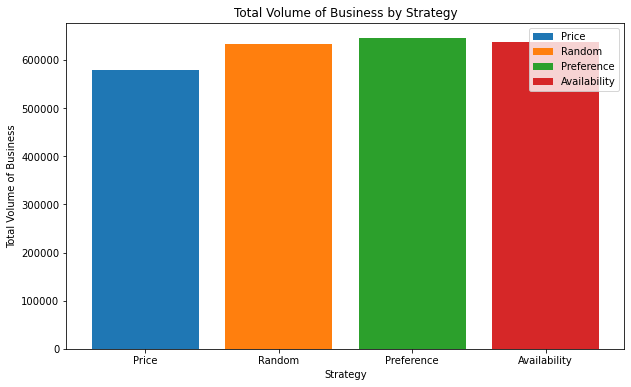

In [63]:
data_manager = DataManager(
    '/Users/yersultanakhmer/Downloads/hotels/hotels.xlsx', 
    '/Users/yersultanakhmer/Downloads/hotels/guests.xlsx', 
    '/Users/yersultanakhmer/Downloads/hotels/preferences.xlsx'
)
allocator = Allocator(data_manager)

# Function to run an allocation strategy and get its report
def run_and_get_report(strategy):
    if strategy == "Price":
        allocator.price_allocation()
    elif strategy == "Random":
        allocator.random_allocation()
    elif strategy == "Preference":
        allocator.customer_preference_allocation()
    elif strategy == "Availability":
        allocator.availability_allocation()
    else:
        raise ValueError("Unknown strategy")
    
    detailed_report_df, summary_df, hotel_earnings = allocator.display_report()
    summary_df['Strategy Name'] = strategy
    return detailed_report_df, summary_df, hotel_earnings

# Function to run all strategies and compile the reports
def run_all_strategies():
    strategies = ["Price", "Random", "Preference", "Availability"]
    reports = {}
    all_detailed_reports = pd.DataFrame()
    all_summary_reports = pd.DataFrame()
    all_hotel_earnings = {}
    top_earning_hotels_all_strategies = {}

    for strategy in strategies:
        detailed_report_df, summary_df, hotel_earnings = run_and_get_report(strategy)
        reports[strategy] = (detailed_report_df, summary_df, hotel_earnings)
        all_detailed_reports = pd.concat([all_detailed_reports, detailed_report_df.assign(Strategy=strategy)])
        all_summary_reports = pd.concat([all_summary_reports, summary_df.assign(Strategy=strategy)])
        all_hotel_earnings[strategy] = hotel_earnings
        top_earning_hotels_all_strategies[strategy] = allocator.get_top_earning_hotels()

    return reports, all_detailed_reports, all_summary_reports, all_hotel_earnings, top_earning_hotels_all_strategies

# call this function to run all strategies and work with the outputs
reports, all_detailed_reports, all_summary_reports, all_hotel_earnings, top_earning_hotels_all_strategies = run_all_strategies()

# Plotting total volume of business for each strategy
plt.figure(figsize=(10, 6))
strategies = all_summary_reports['Strategy Name'].unique()
for strategy in strategies:
    plt.bar(strategy, all_summary_reports[all_summary_reports['Strategy Name'] == strategy]['Total volume of business'].sum(), label=strategy)

plt.xlabel('Strategy')
plt.ylabel('Total Volume of Business')
plt.title('Total Volume of Business by Strategy')
plt.legend()
plt.show()



## Customer Satisfaction Rate by Strategy

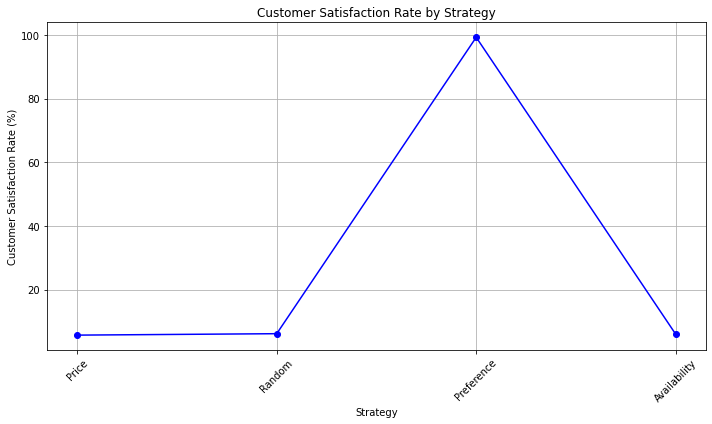

In [64]:
# Plot customer satisfaction rates for each strategy
plt.figure(figsize=(10, 6))
satisfaction_rates = [float(row['Customer satisfaction rate'].strip('%')) for _, row in all_summary_reports.iterrows()]
plt.plot(strategies, satisfaction_rates, marker='o', linestyle='-', color='blue')
plt.xlabel('Strategy')
plt.ylabel('Customer Satisfaction Rate (%)')
plt.title('Customer Satisfaction Rate by Strategy')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Earnings by using Price Strategy

In [65]:
print(reports['Price'][0])  # detailed_report_df for 'Price'

# Save a report to an Excel file
reports['Price'][0].to_excel('price_strategy_report.xlsx', index=False)


           Guest Allocated Hotel  Satisfaction Rate (%)  Earned Money
0        guest_1        hotel_49                      0         45.50
1        guest_2        hotel_49                      0         50.00
2        guest_3        hotel_49                      0         46.50
3        guest_4        hotel_49                      0         50.00
4        guest_5        hotel_49                      0         45.00
...          ...             ...                    ...           ...
3995  guest_3996         hotel_1                      0        273.00
3996  guest_3997         hotel_1                      0        232.05
3997  guest_3998         hotel_1                      0        253.89
3998  guest_3999         hotel_1                      0        251.16
3999  guest_4000         hotel_1                    100        253.89

[4000 rows x 4 columns]


## Earnings by using Availabilty Strategy

In [66]:
print(reports['Availability'][0])  # detailed_report_df for 'Price'

# Save a report to an Excel file
reports['Availability'][0].to_excel('availability_strategy_report.xlsx', index=False)


           Guest Allocated Hotel  Satisfaction Rate (%)  Earned Money
0        guest_1        hotel_11                      0        205.66
1        guest_2        hotel_11                    100        226.00
2        guest_3        hotel_11                      0        210.18
3        guest_4        hotel_11                      0        226.00
4        guest_5        hotel_11                      0        203.40
...          ...             ...                    ...           ...
3995  guest_3996       hotel_286                      0        207.00
3996  guest_3997       hotel_286                      0        175.95
3997  guest_3998       hotel_286                      0        192.51
3998  guest_3999       hotel_286                      0        190.44
3999  guest_4000       hotel_286                      0        192.51

[4000 rows x 4 columns]


## Earnings by using Random Strategy

In [67]:
print(reports['Random'][0])  # detailed_report_df for 'Price'

# Save a report to an Excel file
reports['Random'][0].to_excel('random_strategy_report.xlsx', index=False)


           Guest Allocated Hotel  Satisfaction Rate (%)  Earned Money
0     guest_2253         hotel_1                      0        262.08
1     guest_3711         hotel_1                      0        232.05
2     guest_3412         hotel_1                      0        259.35
3     guest_3068         hotel_1                      0        259.35
4     guest_3187         hotel_1                      0        229.32
...          ...             ...                    ...           ...
3995  guest_3356       hotel_347                      0        190.08
3996  guest_2538       hotel_347                      0        205.20
3997  guest_2811       hotel_347                      0        209.52
3998  guest_3478       hotel_347                      0        181.44
3999  guest_2864       hotel_347                      0        211.68

[4000 rows x 4 columns]


## Earnings by using Preference Strategy

In [68]:
print(reports['Preference'][0])  # detailed_report_df for 'Price'

# Save a report to an Excel file
reports['Preference'][0].to_excel('preference_strategy_report.xlsx', index=False)


           Guest Allocated Hotel  Satisfaction Rate (%)  Earned Money
0        guest_1       hotel_168                    100        271.18
1       guest_10        hotel_60                    100        242.00
2      guest_100        hotel_73                    100        230.51
3     guest_1000       hotel_396                    100        197.16
4     guest_1001       hotel_109                    100         54.27
...          ...             ...                    ...           ...
3995   guest_995       hotel_354                    100         45.76
3996   guest_996        hotel_13                      0        168.30
3997   guest_997       hotel_356                    100        193.44
3998   guest_998       hotel_381                    100        240.12
3999   guest_999        hotel_13                      0        168.30

[4000 rows x 4 columns]


## Bar Plot of Preferences strategy

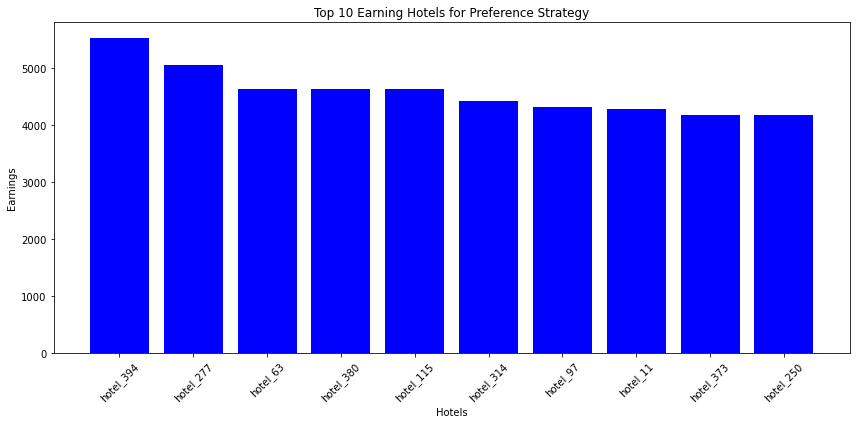

In [69]:
# Plot for Top Earning Hotels for a Preferences strategy
chosen_strategy = 'Preference'  
top_earnings_df = pd.DataFrame(top_earning_hotels_all_strategies[chosen_strategy], columns=["Hotel", "Earnings"])
hotels, earnings = zip(*top_earning_hotels_all_strategies[chosen_strategy])
plt.figure(figsize=(12, 6))
plt.bar(hotels, earnings, color='blue')
plt.xlabel('Hotels')
plt.ylabel('Earnings')
plt.title(f'Top 10 Earning Hotels for {chosen_strategy} Strategy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Bar Plot of Price strategy


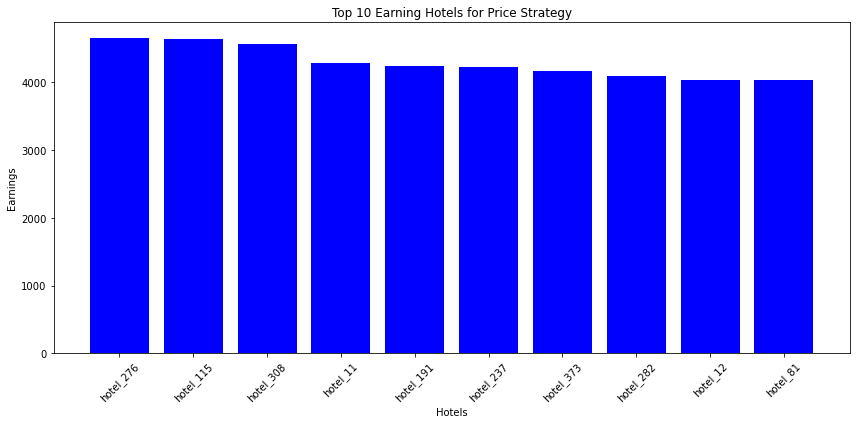

In [70]:
# Plot for Top Earning Hotels for a Price strategy
chosen_strategy = 'Price'  
top_earnings_df = pd.DataFrame(top_earning_hotels_all_strategies[chosen_strategy], columns=["Hotel", "Earnings"])
hotels, earnings = zip(*top_earning_hotels_all_strategies[chosen_strategy])
plt.figure(figsize=(12, 6))
plt.bar(hotels, earnings, color='blue')
plt.xlabel('Hotels')
plt.ylabel('Earnings')
plt.title(f'Top 10 Earning Hotels for {chosen_strategy} Strategy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Bar Plot of Random strategy


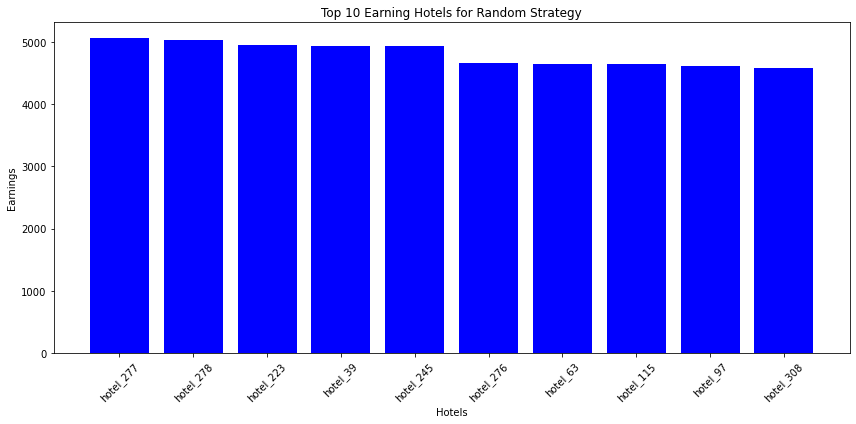

In [71]:
# Plot for Top Earning Hotels for a Random strategy
chosen_strategy = 'Random'  
top_earnings_df = pd.DataFrame(top_earning_hotels_all_strategies[chosen_strategy], columns=["Hotel", "Earnings"])
hotels, earnings = zip(*top_earning_hotels_all_strategies[chosen_strategy])
plt.figure(figsize=(12, 6))
plt.bar(hotels, earnings, color='blue')
plt.xlabel('Hotels')
plt.ylabel('Earnings')
plt.title(f'Top 10 Earning Hotels for {chosen_strategy} Strategy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Bar Plot of Availability strategy


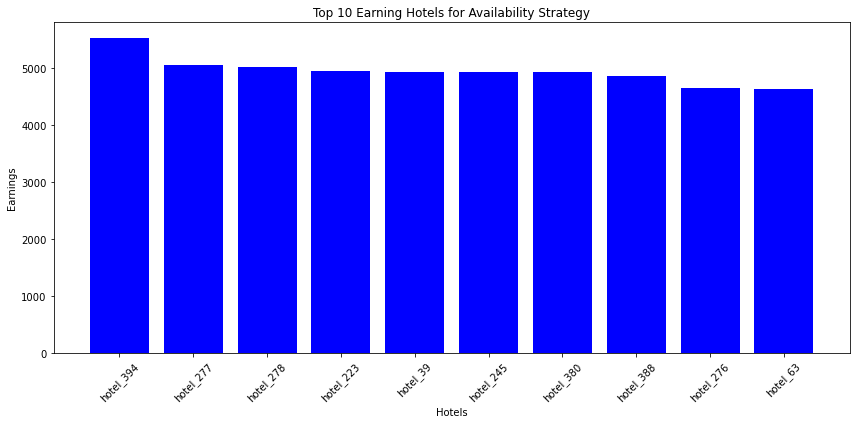

In [72]:
# Plot for Top Earning Hotels for a Availability  strategy
chosen_strategy = 'Availability' 
top_earnings_df = pd.DataFrame(top_earning_hotels_all_strategies[chosen_strategy], columns=["Hotel", "Earnings"])
hotels, earnings = zip(*top_earning_hotels_all_strategies[chosen_strategy])
plt.figure(figsize=(12, 6))
plt.bar(hotels, earnings, color='blue')
plt.xlabel('Hotels')
plt.ylabel('Earnings')
plt.title(f'Top 10 Earning Hotels for {chosen_strategy} Strategy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## All Reports for each strategy

In [73]:
# Run all strategies and display the results
all_reports = run_all_strategies_and_display_results()


Strategy: Price
 Number of customers accommodated  Number of rooms occupied  Total volume of business Customer satisfaction rate Strategy Name
                             4000                      4000                 579540.29                     5.675%         Price


Strategy: Random
 Number of customers accommodated  Number of rooms occupied  Total volume of business Customer satisfaction rate Strategy Name
                             4000                      4000                 633766.61                       6.0%        Random


Strategy: Preference
 Number of customers accommodated  Number of rooms occupied  Total volume of business Customer satisfaction rate Strategy Name
                             4000                      4000                 645153.36                    99.275%    Preference


Strategy: Availability
 Number of customers accommodated  Number of rooms occupied  Total volume of business Customer satisfaction rate Strategy Name
                            